# Yu-Gi-Oh! Trading Card Game Analysis

![alt text](C:/Users/Robin/Documents/nosql_project/ygo_logo.jpg "Title")

<h1>Table of Contents</h1>
<div class="toc">
  <ul>
    <li>
      <a href="#1-Summary">1 Summary</a>
    </li>
    <li>
      <a href="#2-Requirements-&amp;-Configuration">2 Requirements &amp; Configuration</a>
    </li>
    <li>
      <a href="#3-ELT-Process">3 ELT Process</a>
      <ul>
        <li>
          <a href="#3.1-DB-Setup">3.1 DB Setup</a>
        </li>
        <li>
          <a href="#3.2-Extract">3.2 Extract</a>
        </li>
          <ul>
            <li>
              <a href="#3.2.1-Fetching-all-the-card-images">3.2.1 Fetching all the card images</a>
            </li>
          </ul>
        <li>
          <a href="#3.3-Load">3.3 Load</a>
        </li>
        <li>
          <a href="#3.4-Transform">3.4 Transform</a>
          <ul>
            <li>
              <a href="#3.4.1-Fixing-Data-Types">3.4.1 Fixing Data Types</a>
            </li>
            <li>
              <a href="#3.4.2-Check-for-duplicates">3.4.2 Check for duplicates</a>
            </li>
          </ul>
        </li>
        <li>
          <a href="#3.5-Data-Structure">3.5 Data Structure</a>
        </li>
      </ul>
    </li>
    <li>
      <a href="#4-Data-Analysis">4 Data Analysis</a>
      <ul>
        <li>
          <a href="#4.1-Which-card-has-the-most-re-printings?">4.1 Which card has the most re-printings?</a>
        </li>
        </ul>
    </li>
    </ul>
        <li>
            <a href="#5-Conclusions">5 Conclusions</a>
        </li>
        <li>
            <a href="#6-Learnings">6 Learnings</a>
        </li>
</div>

<div style="page-break-after: always;"></div>

# 1 Summary

The Yu-Gi-Oh! Trading Card Game (TCG) is a captivating, strategic duel card game that has enthralled players worldwide since its inception in Japan in 1999. Based on the fictional game of Duel Monsters created by manga artist Kazuki Takahashi, Yu-Gi-Oh! TCG involves two players facing off in a match where the objective is to reduce the opponent's life points to zero using a carefully assembled deck of cards. The game features a diverse array of cards, including Monsters, Spells, and Traps, each with unique abilities and strategies for use in battle. Players must skillfully navigate the complexities of deck building, anticipate their opponent's moves, and execute their strategies with precision to emerge victorious. Beyond its compelling gameplay, Yu-Gi-Oh! TCG boasts a rich lore, drawing from the narratives of the manga and anime series, making it not just a game but a journey into a meticulously crafted world of fantasy and competition. With its combination of deep strategic gameplay, an expansive universe of characters and cards, and a dedicated global community, Yu-Gi-Oh! TCG continues to be a beloved pastime and competitive endeavor for millions of fans around the world.

# 2 Requirements & Configuration

In [1]:
import pymongo
import pprint as pp
import pandas as pd
import requests
import time
from IPython.display import display, Image
from PIL import Image as PILImage
import io
import base64
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# possible pandas option to set here
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_colwidth', 50)

In [3]:
API_URL = "https://db.ygoprodeck.com/api/v7/cardinfo.php?misc=yes"
CNX_STR = "mongodb://localhost:27017"

<div style="page-break-after: always;"></div>

# 3 ELT-Process

The ELT process consists of three main steps: Extract, Load, and Transform. In the Extract step, we will fetch the card data from multiple Yu-Gi-Oh! API endpoints and download the card images. In the Load step, we will insert the data into the MongoDB database that is locally hosted and run in a Docker container. In the Transform step, we will clean and structure the data to prepare it for analysis.

<img src="C:/Users/Robin/Documents/nosql_project/images/process_diagram.png" alt="alt text" width="1000" height="300"/>

## 3.1 DB Setup

In [4]:
# connect to the database
client = pymongo.MongoClient(CNX_STR)

# specify db and collections
db = client["ygo_cards"]
cards = db["card_info"]
images = db['card_images']
card_sets = db['card_sets']

# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [5]:
db.list_collection_names()

['card_info', 'card_images', 'rarities_per_set', 'card_sets']

<div style="page-break-after: always;"></div>

## 3.2 Extract

We will first fetch the card data from the API and have a look at it. The API provides information about each card, including its name, type, attribute, level, ATK/DEF points, card text, and more.

In [9]:
# downloading all the cards from the API
r = requests.get(API_URL)
data = r.json()

In [10]:
# having a look at the first card
pp.pprint(data['data'][1])

{'archetype': 'Alien',
 'card_images': [{'id': 64163367,
                  'image_url': 'https://images.ygoprodeck.com/images/cards/64163367.jpg',
                  'image_url_cropped': 'https://images.ygoprodeck.com/images/cards_cropped/64163367.jpg',
                  'image_url_small': 'https://images.ygoprodeck.com/images/cards_small/64163367.jpg'}],
 'card_prices': [{'amazon_price': '0.50',
                  'cardmarket_price': '0.12',
                  'coolstuffinc_price': '0.25',
                  'ebay_price': '1.25',
                  'tcgplayer_price': '0.20'}],
 'card_sets': [{'set_code': 'GLAS-EN062',
                'set_name': "Gladiator's Assault",
                'set_price': '0',
                'set_rarity': 'Common',
                'set_rarity_code': '(C)'}],
 'desc': 'Each time an A-Counter(s) is removed from play by a card effect, '
         'place 1 A-Counter on this card. When this card is destroyed, '
         'distribute the A-Counters on this card among face

### 3.2.1 Fetching all the card images

The API provides a URL to the image of each card, we can download the images and store them in the database as base64 encoded strings.
A card can have multiple images, in the case of multiple images we will only store the first image, since the images take up a considerable amount of space.

In [ ]:
# loop through all the cards and download the images
for card in data['data']:
    card_name = card['name']
    image_url = card['card_images'][0]['image_url']
    image_response = requests.get(image_url)
    
    # Encode the image to base64
    image_b64 = base64.b64encode(image_response.content)
    
    # Save the encoded image to MongoDB
    images.insert_one({
        'name': card_name,
        'image': image_b64
    })
    time.sleep(0.1) # delay to not exceed the rate limit

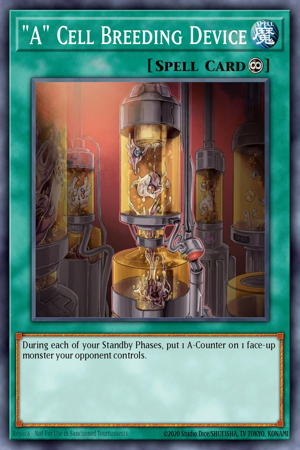

In [21]:
def display_resized_image(image_name=None, new_size=(300, 450)):
    if image_name is None:
        r = images.find_one()
    else:
        # Retrieve the image from the database
        r = images.find_one({"name": image_name})

    # Decode the base64-encoded image
    image_data = base64.b64decode(r['image'])

    # Convert the binary data to a PIL Image object
    image_new = PILImage.open(io.BytesIO(image_data))

    # Resize the image
    resized_image = image_new.resize(new_size)

    # Display the resized image
    display(resized_image)
    
# Display a resized image
display_resized_image()

<div style="page-break-after: always;"></div>

## 3.3 Load

In [ ]:
%%capture
# we can easily insert the list containing all the data into the database
cards.insert_many(data['data'])

In [5]:
# check if the data is in the database
cards.count_documents({})

13030

In [8]:
# show random card
pp.pprint(cards.find_one())

{'_id': ObjectId('660592ebef8a28605d753112'),
 'archetype': 'Alien',
 'card_images': [{'id': 34541863,
                  'image_url': 'https://images.ygoprodeck.com/images/cards/34541863.jpg',
                  'image_url_cropped': 'https://images.ygoprodeck.com/images/cards_cropped/34541863.jpg',
                  'image_url_small': 'https://images.ygoprodeck.com/images/cards_small/34541863.jpg'}],
 'card_prices': [{'amazon_price': 24.45,
                  'cardmarket_price': 0.07,
                  'coolstuffinc_price': 0.25,
                  'ebay_price': 0.99,
                  'tcgplayer_price': 0.17}],
 'card_sets': [{'set_code': 'FOTB-EN043',
                'set_name': 'Force of the Breaker',
                'set_price': 0.0,
                'set_rarity': 'Common',
                'set_rarity_code': '(C)'}],
 'desc': 'During each of your Standby Phases, put 1 A-Counter on 1 face-up '
         'monster your opponent controls.',
 'frameType': 'spell',
 'id': 34541863,
 'misc_inf

In [9]:
# check the different types of card types
r = cards.aggregate([
    {"$group": {"_id": "$type"}},
    {"$sort": {"_id": 1}}
])
pd.DataFrame(r)

,_id
0,Effect Monster
1,Flip Effect Monster
2,Fusion Monster
3,Gemini Monster
4,Link Monster
5,Normal Monster
6,Normal Tuner Monster
7,Pendulum Effect Fusion Monster
8,Pendulum Effect Monster
9,Pendulum Effect Ritual Monster


### 3.3.1 Additional Set Information

Using the cardsets endpoint from the API we can get additional valuable information about the sets the cards were released in, such as the release date and the number of cards in the set.

In [10]:
# get dates for the sets
r = requests.get("https://db.ygoprodeck.com/api/v7/cardsets.php")
data = r.json()

data[0]

{'set_name': '2-Player Starter Deck: Yuya & Declan',
 'set_code': 'YS15',
 'num_of_cards': 42,
 'tcg_date': '2015-05-28',
 'set_image': 'https://images.ygoprodeck.com/images/sets/YS15.jpg'}

In [ ]:
%%capture
# insert additional set information into the database
card_sets.insert_many(data)

In [11]:
card_sets.find_one()

{'_id': ObjectId('66069f9eef8a28605d7596df'),
 'set_name': '2-Player Starter Deck: Yuya & Declan',
 'set_code': 'YS15',
 'num_of_cards': 42,
 'tcg_date': datetime.datetime(2015, 5, 28, 0, 0),
 'set_image': 'https://images.ygoprodeck.com/images/sets/YS15.jpg'}

<div style="page-break-after: always;"></div>

## 3.4 Transform

### 3.4.1 Fixing Data Types

Converting the date in the card_sets collection to a proper date object results in an error, this is due to the fact that some of the dates are not in the correct format, being shown as 0000-00-00. We have to handle the date conversion differently and will treat this case with a missing value

In [ ]:
%%capture
card_sets.update_many(
    {}, 
    [
        {"$set": {
            "tcg_date": {
                "$cond": {
                    "if": {"$ne": ["$tcg_date", "0000-00-00"]},  # Check if tcg_date is not '0000-00-00'
                    "then": {"$toDate": "$tcg_date"},  # If true, convert tcg_date to date
                    "else": None  # If false, set tcg_date to None or choose another placeholder
                }
            }
        }}
    ]
)

We also need to convert the tcg_date and ocg_date fields in the card collection to datetime objects. Due to these dates being stored in an array in a document, we need to choose a slightly different approach. We will iterate over each document in the collection, convert the dates to datetime objects, and update the document with the modified dates.  

In [ ]:
# Iterate over each document in the collection
for card in cards.find():
    # Iterate over each item in the misc_info array (if it exists)
    for misc in card.get("misc_info", []):
        # Convert tcg_date and ocg_date to datetime objects
        if 'tcg_date' in misc:
            misc['tcg_date'] = datetime.strptime(misc['tcg_date'], "%Y-%m-%d")
        if 'ocg_date' in misc:
            misc['ocg_date'] = datetime.strptime(misc['ocg_date'], "%Y-%m-%d")
    
    # Update the document with the modified misc_info array
    cards.update_one(
        {"_id": card["_id"]},
        {"$set": {"misc_info": card["misc_info"]}}
    )

Now we also need to convert the numbers in the card_prices array of the card collection to float values. We will iterate over each document in the collection, convert the prices to float values, and update the document with the modified prices.

In [ ]:
# Iterate over each document in the collection
for card in cards.find():
    # Check if card_prices exists and is not empty
    if 'card_prices' in card and card['card_prices']:
        # Convert each price to float
        for price_info in card['card_prices']:
            price_info['cardmarket_price'] = float(price_info['cardmarket_price'])
            price_info['tcgplayer_price'] = float(price_info['tcgplayer_price'])
            price_info['ebay_price'] = float(price_info['ebay_price'])
            price_info['amazon_price'] = float(price_info['amazon_price'])
            price_info['coolstuffinc_price'] = float(price_info['coolstuffinc_price'])

        # Update the document with the modified card_prices array
        cards.update_one(
            {"_id": card["_id"]},
            {"$set": {"card_prices": card['card_prices']}}
        )

The set_price field in the card_sets array of the cards collection is also stored as a string, we can convert this to a float value.

In [ ]:
# Iterate over each document in the collection
for card in cards.find():
    # Check if card_sets exists and is not empty
    if 'card_sets' in card and card['card_sets']:
        # Convert set_price to float
        for set_info in card['card_sets']:
            set_info['set_price'] = float(set_info['set_price'])

        # Update the document with the modified card_sets array
        cards.update_one(
            {"_id": card["_id"]},
            {"$set": {"card_sets": card['card_sets']}}
        )

### 3.4.2 Check for duplicates

In [11]:
# check if there are any duplicate ids
cards.count_documents({}) == cards.count_documents({"id": {"$exists": True}})

True

In [12]:
# check if there are any duplicate names
cards.count_documents({}) == cards.count_documents({"name": {"$exists": True}})

True

In [13]:
images.count_documents({}) == images.count_documents({"name": {"$exists": True}})

True

In [14]:
card_sets.count_documents({}) == card_sets.count_documents({"set_name": {"$exists": True}})

True

There seem to be no duplicates in the most important fields of our collections.

<div style="page-break-after: always;"></div>

## 3.5 Data Structure

The data is structured in a way that the card collection contains all the information about the cards, including the card prices, card sets, and card images. The card sets collection contains additional information about the sets the cards were released in.

<img src="C:/Users/Robin/Documents/nosql_project/images/card_diagram.png" alt="alt text" width="1000" height="300"/>

The downloaded images will be kept in a separate collection and not embedded, since the images take up a large amount of space and are not needed for all queries.
We therefore have a simple card image class:

In [ ]:
display(Image(filename='images/card_image_diagram.png', width=200, height=100))

The additional card set information will also be kept in a separate collection, since embedding the information in the card collection would lead to a lot of redundant data. This will make querying the card data more efficient, but on the other hand we have to perform a lookup to get the additional set information.

<img src="C:/Users/Robin/Documents/nosql_project/images/cardset_diagram.png" alt="alt text" width="100" height="10"/>

<div style="page-break-after: always;"></div>

# 4 Data Analysis

Ideas for aggregation pipelines/analysis:
- Which card has the most re-printings? (occurs in the most sets)
- Which card has the most different versions? (e.g. normal, rare, ultra rare, etc.)
- Which are the most expensive cards? (e.g. top 10)
- Which are the most powerful cards? (ATK points) (e.g. top 10)
- Which set contains the most expensive cards? (make plot of multiple sets in one graph)
- Analyze rarity versions throughout the years (e.g. how many ultra rares in 2020 vs 2021)

## 4.1 Which card has the most re-printings?
Throughout the years the same card can be re-printed in different sets, we can count the number of times a card occurs in different sets to determine which card has the most re-printings.

In [15]:
# most re-printings
r = cards.aggregate([
    {"$unwind": "$card_sets"},
    {"$group": {"_id": "$name", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}},
    {"$limit": 10}
])

pd.DataFrame(r)

,_id,count
0,Blue-Eyes White Dragon,62
1,Mystical Space Typhoon,59
2,Call of the Haunted,53
3,Dark Magician,53
4,Cyber Dragon,45
5,Polymerization,41
6,Dark Hole,40
7,Book of Moon,39
8,Swords of Revealing Light,39
9,Reinforcement of the Army,38


The card "Blue-Eyes White Dragon" has the most re-printings with 62 different versions, closely followed by the card Mystical Space Typhoon. This is probably not a surprise to most people who are familiar with Yu-Gi-Oh!, since it is one of the most iconic cards in the game. We can have a look at the card by printing the first version of the card.

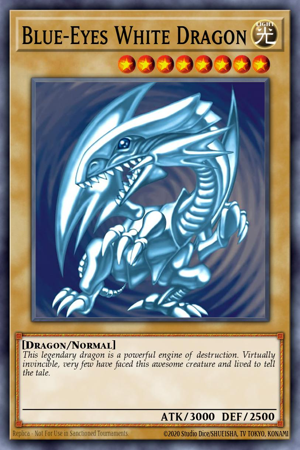

In [16]:
# display an image of the card
display_resized_image("Blue-Eyes White Dragon")

## Find the most expensive cards based on set prices
As we saw previously, a card can have multiple versions with different prices. Card prices of rare limited cards can be quite high and play a major role in the trading card game community.
We can determine the most expensive cards by looking at the respective set prices of each card and sorting them in descending order.

In [16]:
# Define the aggregation pipeline
pipeline = [
    # Unwind the card_sets array to process each element separately
    {"$unwind": "$card_sets"},
    # Convert set_price from string to float (assuming all prices are valid floats)
    #{"$addFields": {"card_sets.set_price": {"$convert": {"input": "$card_sets.set_price", "to": "double", "onError": 0}}}},
    # Sort by set_price in descending order to ensure the highest price comes first
    {"$sort": {"card_sets.set_price": -1}},
    # Limit the results to 1 to get the top most expensive card set
    {"$limit": 10},
    # Project the results to format the output
    {"$project": {
        "_id": 0,
        "card_id": "$id",
        "name": "$name",
        "set_name": "$card_sets.set_name",
        "set_code": "$card_sets.set_code",
        "set_rarity": "$card_sets.set_rarity",
        "set_price": "$card_sets.set_price"
    }}
]

# Execute the aggregation query
result = list(cards.aggregate(pipeline))
df = pd.DataFrame(result)
df

,card_id,name,set_name,set_code,set_rarity,set_price
0,57728570,Crush Card Virus,Shonen Jump Championship 2007 Prize Card A,SJCS-EN004,Ultra Rare,115033.33
1,81059524,Des Volstgalph,Shonen Jump Championship 2005 Prize Card,SJC-EN002,Ultra Rare,95074.95
2,69015963,Cyber-Stein,Shonen Jump Championship 2004 Prize Card,SJC-EN001,Ultra Rare,24067.80
3,75500286,Gold Sarcophagus,Shonen Jump Championship 2007 Prize Card B,SJCS-EN005,Ultra Rare,24000.00
4,75500286,Gold Sarcophagus,Pharaoh Tour 2007 promotional cards,PT03-EN001,Ultra Rare,21127.30
5,85771019,Darklord Asmodeus,Yu-Gi-Oh! Championship Series 2010 Prize Cards,YCSW-EN001,Ultra Rare,20299.50
6,55713623,Shrink,Shonen Jump Championship 2006 Prize Card,SJC-EN003,Ultra Rare,18530.00
7,88643579,Dark End Dragon,Shonen Jump Championship 2009 Prize Card,SJCS-EN007,Ultra Rare,14693.33
8,54343893,Vice Dragon,Duel Disk - Yusei Version,DDY1-EN001,Ultra Rare,10001.09
9,63746411,Number 106: Giant Hand,Yu-Gi-Oh! Championship Series 2013 Prize Card,YCSW-EN006,Ultra Rare,8915.68


The most expensive card is the "Crush Card Virus" from the "Shonen Jump Championship 2007 Prize Card A" Set, with a price of 115'000 USD. Based on the set name, this card was only available by winning a competitive tournament, hence being one of the rarest cards and therefore the most expensive one based on the available prizes.

<Axes: title={'center': 'Top 10 Most Expensive Card Sets'}, xlabel='Card Name', ylabel='Set Price'>

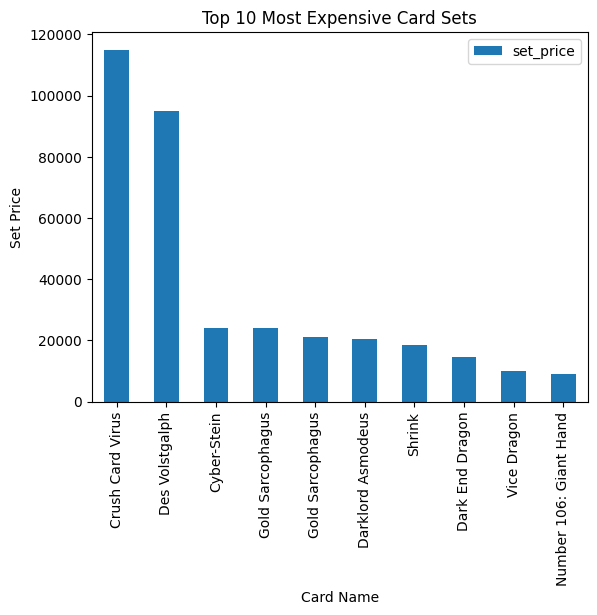

In [18]:
pd.DataFrame(result).plot(kind='bar', x='name', y='set_price', title='Top 10 Most Expensive Card Sets', ylabel='Set Price', xlabel='Card Name')

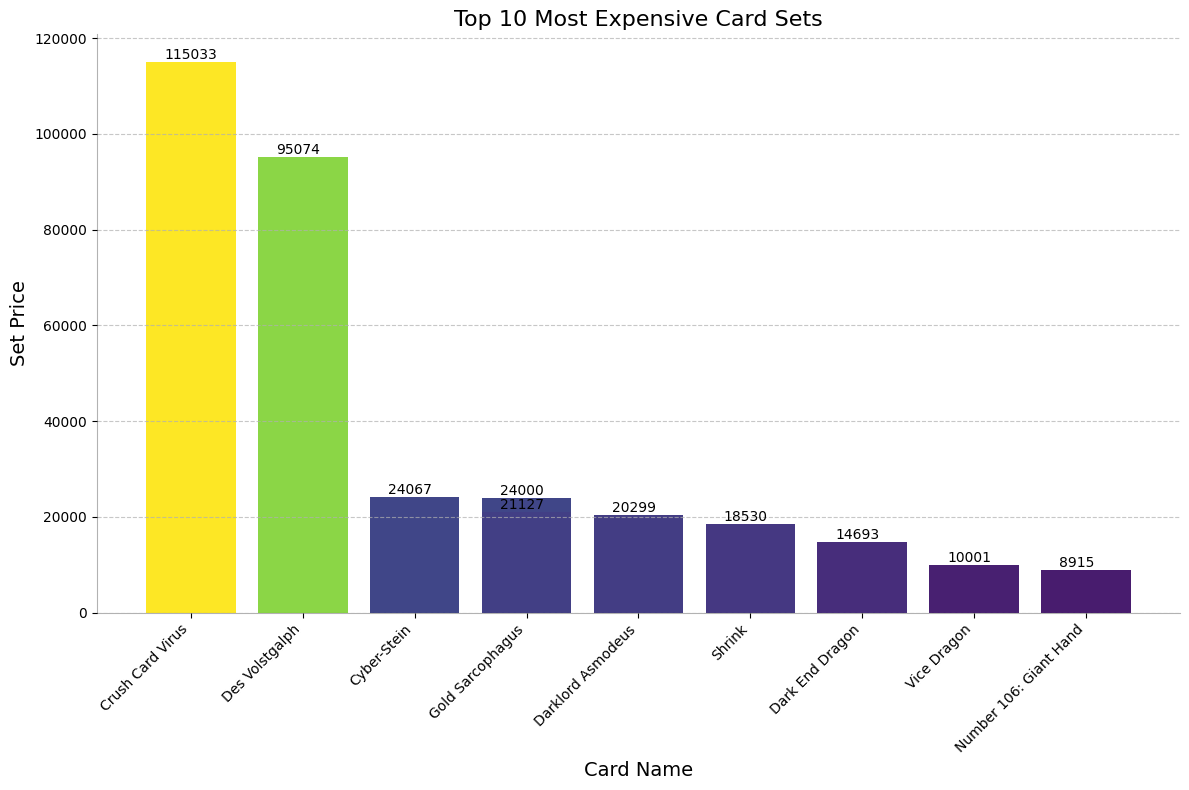

In [17]:
# make a nice plot
plt.figure(figsize=(12, 8))
bars = plt.bar(df['name'], df['set_price'], color=plt.cm.viridis(df['set_price'] / df['set_price'].max()))

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/5, yval, int(yval), va='bottom')  # Add the data value on top of each bar
    
# Set title and labels with increased font sizes
plt.title('Top 10 Most Expensive Cards', fontsize=16)
plt.xlabel('Card Name', fontsize=14)
plt.ylabel('Set Price', fontsize=14)

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=45, ha='right', fontsize=10)

# Lighten borders and gridlines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_alpha(0.3)
plt.gca().spines['left'].set_alpha(0.3)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to make room for the rotated x-axis labels
plt.tight_layout()

# Show the plot
plt.show()

## Sets containing the most expensive cards
Knowing which card sets contain the most expensive cards can be quite valuable, in case of a stored unopened pack of that specific set.
We can determine which set contains the most expensive cards by calculating the total price of all cards in each set and sorting the results in descending order.

In [19]:
# Define the aggregation pipeline
pipeline = [
    # Unwind the card_sets array to process each element separately
    {"$unwind": "$card_sets"},
    # Convert set_price from string to float (assuming all prices are valid floats)
    #{"$addFields": {"card_sets.set_price": {"$convert": {"input": "$card_sets.set_price", "to": "double", "onError": 0}}}},
    # Group by set_name to calculate the total price of all cards in the set
    {"$group": {
        "_id": "$card_sets.set_name",
        "total_price": {"$sum": "$card_sets.set_price"}
    }},
    # Sort by total_price in descending order to ensure the highest price comes first
    {"$sort": {"total_price": -1}},
    # Limit the results to 10 to get the top most expensive card sets
    {"$limit": 10},
    # Project the results to format the output
    {"$project": {
        "_id": 0,
        "set_name": "$_id",
        "total_price": 1
    }}
]

# Execute the aggregation query
result = list(cards.aggregate(pipeline))
df = pd.DataFrame(result)
df

,total_price,set_name
0,115033.33,Shonen Jump Championship 2007 Prize Card A
1,95074.95,Shonen Jump Championship 2005 Prize Card
2,30547.47,Yu-Gi-Oh! Championship Series 2010 Prize Cards
3,25119.51,Retro Pack
4,24067.80,Shonen Jump Championship 2004 Prize Card
5,24000.00,Shonen Jump Championship 2007 Prize Card B
6,21151.04,Pharaoh Tour 2007 promotional cards
7,18530.00,Shonen Jump Championship 2006 Prize Card
8,14693.33,Shonen Jump Championship 2009 Prize Card
9,13047.42,Yu-Gi-Oh! Championship Series 2011 Prize Card


A visual representation can help to compare the different prizes:

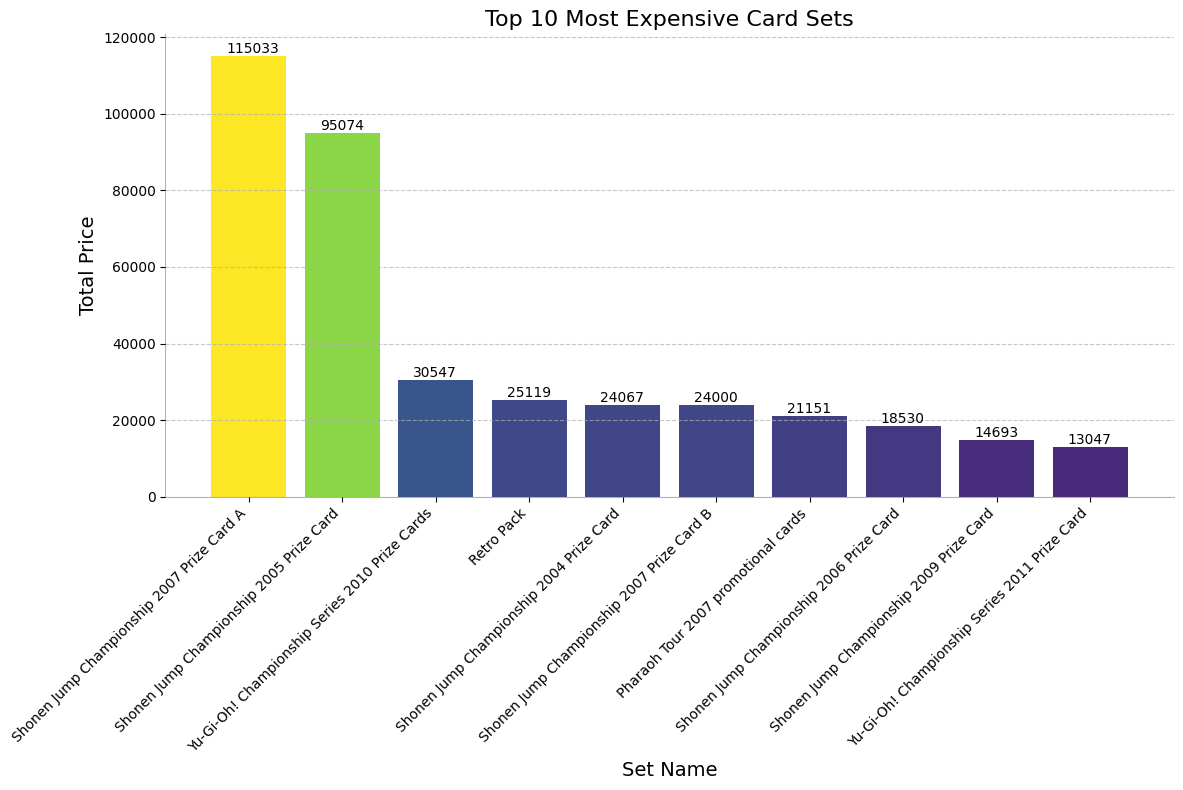

In [20]:
# Create the bar plot with enhancements
plt.figure(figsize=(12, 8))
bars = plt.bar(df['set_name'], df['total_price'], color=plt.cm.viridis(df['total_price'] / df['total_price'].max()))

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/5, yval, int(yval), va='bottom')  # Add the data value on top of each bar

# Set title and labels with increased font sizes
plt.title('Top 10 Most Expensive Card Sets', fontsize=16)
plt.xlabel('Set Name', fontsize=14)
plt.ylabel('Total Price', fontsize=14)

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=45, ha='right', fontsize=10)

# Lighten borders and gridlines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_alpha(0.3)
plt.gca().spines['left'].set_alpha(0.3)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to make room for the rotated x-axis labels
plt.tight_layout()

# Show the plot
plt.show()

## Card Rarities per Set Over the Years

In [ ]:
pipeline = [
    # Unwind the card_sets array to process each element separately
    {"$unwind": "$card_sets"},
    
    # Lookup to join date information from the second collection
    {"$lookup": {
        "from": "card_sets", 
        "localField": "card_sets.set_name",
        "foreignField": "set_name",
        "as": "set_details"
    }},
    
    # Unwind the result of the lookup to process each joined document
    {"$unwind": "$set_details"},
    
    # Group by set_name and set_rarity to calculate the total number of rare cards in each set
    {"$group": {
        "_id": {"set_name": "$card_sets.set_name", "set_rarity": "$card_sets.set_rarity", "tcg_date": "$set_details.tcg_date"},
        "total_rare_cards": {"$sum": 1}
    }},
    
    # Sort by set_name in ascending order to ensure the results are ordered by set name
    {"$sort": {"_id.set_name": 1}},
    
    # Project the results to format the output, now including the tcg_date
    {"$project": {
        "_id": 0,
        "set_name": "$_id.set_name",
        "set_rarity": "$_id.set_rarity",
        "tcg_date": "$_id.tcg_date",
        "total_rare_cards": 1
    }},
    
    # Output the results into a new collection
    {"$out": "rarities_per_set"}
]

# Execute the aggregation query
cards.aggregate(pipeline)

In [22]:
rarities_per_set = db.rarities_per_set
pd.DataFrame(rarities_per_set.find()).head(10)

,_id,total_rare_cards,set_name,set_rarity,tcg_date
0,660a87e0b6375cad3baec178,2,2-Player Starter Deck: Yuya & Declan,Ultra Rare,2015-05-28
1,660a87e0b6375cad3baec179,38,2-Player Starter Deck: Yuya & Declan,Common,2015-05-28
2,660a87e0b6375cad3baec17a,2,2-Player Starter Deck: Yuya & Declan,Super Rare,2015-05-28
3,660a87e0b6375cad3baec17b,8,2-Player Starter Set,Ultra Rare,2024-01-26
4,660a87e0b6375cad3baec17c,79,2-Player Starter Set,Common,2024-01-26
5,660a87e0b6375cad3baec17d,2,2013 Collectible Tins Wave 1,Secret Rare,2013-08-30
6,660a87e0b6375cad3baec17e,7,2013 Collectible Tins Wave 1,Super Rare,2013-08-30
7,660a87e0b6375cad3baec17f,7,2013 Collectible Tins Wave 2,Super Rare,2013-11-22
8,660a87e0b6375cad3baec180,2,2013 Collectible Tins Wave 2,Secret Rare,2013-11-22
9,660a87e0b6375cad3baec181,110,2014 Mega-Tin Mega Pack,Common,2014-08-28


In [24]:
pipeline = [
    # First, ensure tcg_date exists and is of a type that can represent a date
    {"$match": {
        "tcg_date": {"$exists": True, "$ne": ""}
    }},
    
    {"$addFields": {
        "year": {"$year": "$tcg_date"}
    }},
    
    # Exclude invalid years (e.g., NaN), the year 2024, and the year 2001
    {"$match": {
        "year": {"$nin": [2024, 2001], "$gte": 0}
    }},
    
    # Bin the rarities into specified categories
    {"$addFields": {
        "binned_rarity": {
            "$switch": {
                "branches": [
                    {"case": {"$eq": ["$set_rarity", "Common"]}, "then": "Common"},
                    {"case": {"$eq": ["$set_rarity", "Rare"]}, "then": "Rare"},
                    {"case": {"$eq": ["$set_rarity", "Ultra Rare"]}, "then": "Ultra Rare"},
                ],
                "default": "Special Rarity"
            }
        }
    }},
    
    # Group by year and binned_rarity
    {"$group": {
        "_id": {"year": "$year", "set_rarity": "$binned_rarity"},
        "total_cards": {"$sum": "$total_rare_cards"}
    }},
    
    # Sort the results by year and set_rarity
    {"$sort": {"_id.year": 1, "_id.set_rarity": 1}},
    
    # Optionally, you can project the results to format the output
    {"$project": {
        "_id": 0,
        "year": "$_id.year",
        "set_rarity": "$_id.set_rarity",
        "total_cards": 1
    }}
]

# Execute the aggregation query
result = rarities_per_set.aggregate(pipeline)
df = pd.DataFrame(result)
df.head(10)

,total_cards,year,set_rarity
0,1082,2002,Common
1,278,2002,Rare
2,377,2002,Special Rarity
3,140,2002,Ultra Rare
4,654,2003,Common
5,161,2003,Rare
6,248,2003,Special Rarity
7,94,2003,Ultra Rare
8,560,2004,Common
9,113,2004,Rare


In [25]:
# Create a pivot table to reshape the data for plotting
df_pivot = df.pivot(index='year', columns='set_rarity', values='total_cards').fillna(0)
df_pivot

set_rarity,Common,Rare,Special Rarity,Ultra Rare
year,,,,
2002,1082,278,377,140
2003,654,161,248,94
2004,560,113,254,69
2005,878,154,229,88
2006,524,147,240,62
2007,536,159,294,60
2008,484,159,303,89
2009,426,150,288,83
2010,378,154,679,91


<Axes: title={'center': 'Distribution of Rare Cards Over the Years'}, xlabel='Year', ylabel='Total Cards'>

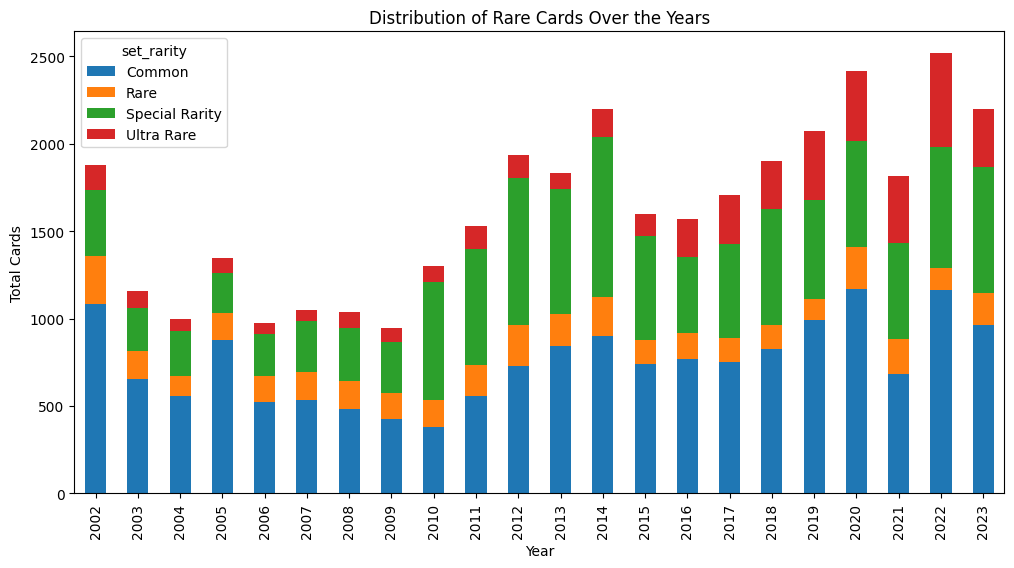

In [26]:
# Plot the data
df_pivot.plot(kind='bar', stacked=True, figsize=(12, 6), title='Distribution of Rare Cards Over the Years', ylabel='Total Cards', xlabel='Year')

## Count Cards by Type

In [24]:
# Define the aggregation pipeline
pipeline = [
    # Group by card type to calculate the total number of cards of each type
    {"$group": {
        "_id": "$type",
        "total_cards": {"$sum": 1}
    }},
    # Sort by total_cards in descending order to ensure the highest count comes first
    {"$sort": {"total_cards": -1}},
    # Project the results to format the output
    {"$project": {
        "_id": 0,
        "card_type": "$_id",
        "total_cards": 1
    }}
]

# Execute the aggregation query
result = list(cards.aggregate(pipeline))
pd.DataFrame(result)

,total_cards,card_type
0,4648,Effect Monster
1,2539,Spell Card
2,1899,Trap Card
3,661,Normal Monster
4,507,XYZ Monster
5,457,Fusion Monster
6,453,Tuner Monster
7,419,Synchro Monster
8,401,Link Monster
9,267,Pendulum Effect Monster


<Axes: title={'center': 'Total Number of Cards by Type'}, xlabel='Card Type', ylabel='Total Cards'>

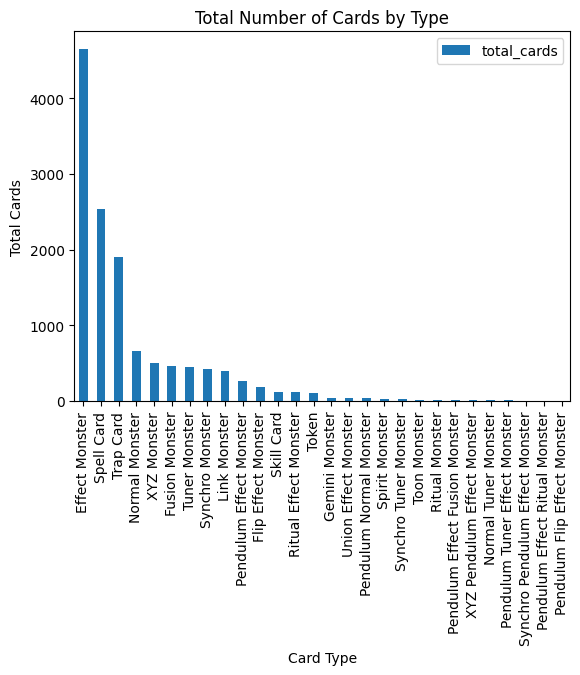

In [25]:
pd.DataFrame(result).plot(kind='bar', x='card_type', y='total_cards', title='Total Number of Cards by Type', ylabel='Total Cards', xlabel='Card Type')

## Average Card Prices by Rarity within a Set

In [23]:
# Define the aggregation pipeline
pipeline = [
    {"$unwind": "$card_sets"},
    {"$group": {
        "_id": {
            "set_name": "$card_sets.set_name",
            "set_rarity": "$card_sets.set_rarity"
        },
        "averageSetPrice": {"$avg": "$card_sets.set_price"}
    }},
    {"$sort": {"_id.set_name": 1, "averageSetPrice": -1}}
]

result = cards.aggregate(pipeline)
pd.DataFrame(result)

,_id,averageSetPrice
0,{'set_name': '2-Player Starter Deck: Yuya & De...,11.920000
1,{'set_name': '2-Player Starter Deck: Yuya & De...,4.801842
2,{'set_name': '2-Player Starter Deck: Yuya & De...,4.510000
3,"{'set_name': '2-Player Starter Set', 'set_rari...",0.000000
4,"{'set_name': '2-Player Starter Set', 'set_rari...",0.000000
...,...,...
2254,"{'set_name': 'Zexal Collection Tin', 'set_rari...",5.830000
2255,"{'set_name': 'Zexal Collection Tin', 'set_rari...",3.523333
2256,"{'set_name': 'Zexal Collection Tin', 'set_rari...",1.495833
2257,"{'set_name': 'Zombie World Structure Deck', 's...",0.000000


## Most trending cards

The number of times a card has been viewed in the database this week (does not include API/external views)

In [19]:
# Define the aggregation pipeline
pipeline = [
    { "$unwind": "$misc_info" },
    { "$sort": { "misc_info.viewsweek": -1 } },
    { "$limit": 10 },
    { "$project": { "name": 1, "viewsweek": "$misc_info.viewsweek" } }
]

result = cards.aggregate(pipeline)
df = pd.DataFrame(result)
df

,_id,name,viewsweek
0,660592ebef8a28605d7533d7,Ash Blossom & Joyous Spring,26338
1,660592ebef8a28605d75479e,Infinite Impermanence,19062
2,660592ebef8a28605d754f8f,"Nibiru, the Primal Being",11518
3,660592ebef8a28605d753e8f,Effect Veiler,11232
4,660592ebef8a28605d755f64,Triple Tactics Talent,10764
5,660592ebef8a28605d753726,Called by the Grave,9412
6,660592ebef8a28605d753e07,Droll & Lock Bird,9361
7,660592ebef8a28605d7556ae,S:P Little Knight,8112
8,660592ebef8a28605d755316,Pot of Prosperity,7852
9,660592ebef8a28605d755b84,Super Starslayer TY-PHON - Sky Crisis,6944


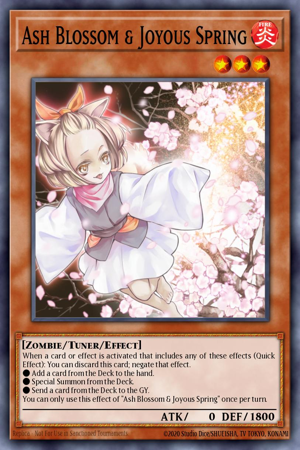

In [22]:
# have a look at the most viewed card this week
display_resized_image(df.iloc[0]['name'])

## Distribution of Cards by Archetype
Find out how many cards belong to each archetype, giving insights into the variety and potential deck strategies.

In [18]:
pipeline = [
    { "$match": { "archetype": { "$exists": True } } },
    { "$group": { "_id": "$archetype", "count": { "$sum": 1 } } },
    { "$sort": { "count": -1 } }
]

result = cards.aggregate(pipeline)
pd.DataFrame(result)

,_id,count
0,Elemental HERO,133
1,Performapal,90
2,Archfiend,88
3,Blackwing,81
4,D/D,65
...,...,...
532,Patissciel,1
533,Bugroth,1
534,Cosmic Synchro Monster,1
535,Paladins of Dragons,1


<div style="page-break-after: always;"></div>

# 5 Conclusions

In this analysis, we explored the Yu-Gi-Oh! Trading Card Game (TCG) data to gain insights into the cards, sets, and prices associated with the game. By extracting, transforming, and loading the data into a MongoDB database, we were able to perform various analyses to uncover interesting trends and patterns within the dataset. Some of the key findings include:
- The card "Blue-Eyes White Dragon" has the most re-printings, with 62 different versions.
- The most expensive card is the "Crush Card Virus" from the "Shonen Jump Championship 2007 Prize Card A" Set, with a price of 115,000 USD.
- The set "Shonen Jump Championship 2007 Prize Card A" contains the most expensive cards, with a total price of 115,000 USD.
- The distribution of rare cards over the years shows an interesting trend in the number of rare cards released each year.
- The most common card type is "Monster", followed by "Spell" and "Trap".
- The average card prices by rarity within a set vary significantly, with some rarities commanding higher prices than others.
- The most viewed card this week is the "Blue-Ejsones White Dragon", indicating its popularity among players and collectors.
- The distribution of cards by archetype provides insights into the variety of deck strategies available to players.
- The analysis of card rarities, prices, and archetypes offers valuable information for players, collectors, and enthusiasts of the Yu-Gi-Oh! TCG.
- The data provides a rich source of information for further exploration and analysis, with opportunities to delve deeper into specific aspects of the game and its cards.
- Overall, the analysis of the Yu-Gi-Oh! TCG data highlights the diversity, complexity, and appeal of the game, making it a fascinating subject for study and exploration.
- The data analysis provides valuable insights into the world of Yu-Gi-Oh! TCG, shedding light on the cards, sets, prices, and trends that shape the game and its community.
- By leveraging the power of MongoDB and aggregation pipelines, we were able to extract meaningful insights from the data and present them in a clear and informative manner.
- The analysis of the Yu-Gi-Oh! TCG data showcases the potential of NoSQL databases for handling complex and diverse datasets, enabling users to explore, analyze, and visualize data in innovative ways.
- The findings from this analysis can inform future research, strategy development, and decision-making in the context of the Yu-Gi-Oh! TCG, offering valuable insights for players, collectors, and enthusiasts alike.
- Overall, the analysis of the Yu-Gi-Oh! TCG data demonstrates the power of data-driven insights in uncovering hidden patterns, trends, and opportunities within a rich and dynamic dataset.
- The analysis of the Yu-Gi-Oh! TCG data provides a comprehensive overview of the game's cards, sets, prices, and trends, offering valuable insights for players, collectors, and enthusiasts.
- By leveraging MongoDB and aggregation pipelines, we were able to extract, transform, and analyze the data to uncover key findings and trends within the dataset.
- The analysis of the Yu-Gi-Oh! TCG data highlights the diversity, complexity, and strategic depth of the game, making it a compelling subject for exploration and analysis.
- The insights gained from the analysis can inform decision-making, strategy development, and research in the context of the Yu-Gi-Oh! TCG, offering valuable perspectives for players, collectors, and fans of the game.

<div style="page-break-after: always;"></div>

# 6 Learnings